In [169]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import random
import numpy as np
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.optim as optim


In [118]:
batch_size = 32

In [127]:
# Define data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.stack([x[0], x[0], x[0]], dim=0)),  # Add 2 more channels by duplicating the first channel
    transforms.Normalize((0.5,), (0.5,)) # Normalize the data to have mean 0.5 and standard deviation 0.5
])

# Download and load the Fashion-MNIST dataset
train_set = datasets.FashionMNIST('~/.pytorch/FashionMNIST_data/', download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST('~/.pytorch/FashionMNIST_data/', download=True, train=False, transform=transform)

In [128]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_set, range(10_000)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [121]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

        self.groups = [[] for _ in range(10)]
        for image, label in self.dataset:
            self.groups[label].append(image)


    def __getitem__(self, index):
        img1, label1 = self.dataset[index]
        # Randomly select a second image
        if random.random() > 0.5:
            # Randomly select a second image from the same class
            index2 = random.randint(0, len(self.groups[label1]) - 1)
            img2 = self.groups[label1][index2]
            return img1, img2, torch.tensor(1, dtype=torch.float32)
        else:
            # Randomly select a second image from a different class
            label2 = random.randint(0, 9)
            while label2 == label1:
                label2 = random.randint(0, 9)
            index2 = random.randint(0, len(self.groups[label2]) - 1)
            img2 = self.groups[label2][index2]
            return img1, img2, torch.tensor(0, dtype=torch.float32)

            
    def __len__(self):
        return len(self.dataset)

In [129]:
# Create dataloaders for the training and testing sets
siamese_train_loader = torch.utils.data.DataLoader(SiameseDataset(torch.utils.data.Subset(train_set, range(5_000))), batch_size=batch_size, shuffle=True)
siamese_test_loader = torch.utils.data.DataLoader(SiameseDataset(test_set), batch_size=batch_size, shuffle=False)

In [123]:
# Define ResNeXt50 model
class ResNeXt50(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNeXt50, self).__init__()
        self.resnext50 = models.resnext50_32x4d(pretrained=True)
        self.resnext50.fc = nn.Linear(2048, num_classes)
    
    def forward(self, x):
        return self.resnext50(x)

In [ ]:
# Define the model
model = ResNeXt50(num_classes=10)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0


In [ ]:
# Save the model
torch.save(model.state_dict(), "model.pth")

In [125]:
model = ResNeXt50(num_classes=10)

# Load the saved model
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [171]:
# Evaluate the model on the test set
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted_label = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted_label == labels).sum().item()
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 86 %


In [71]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

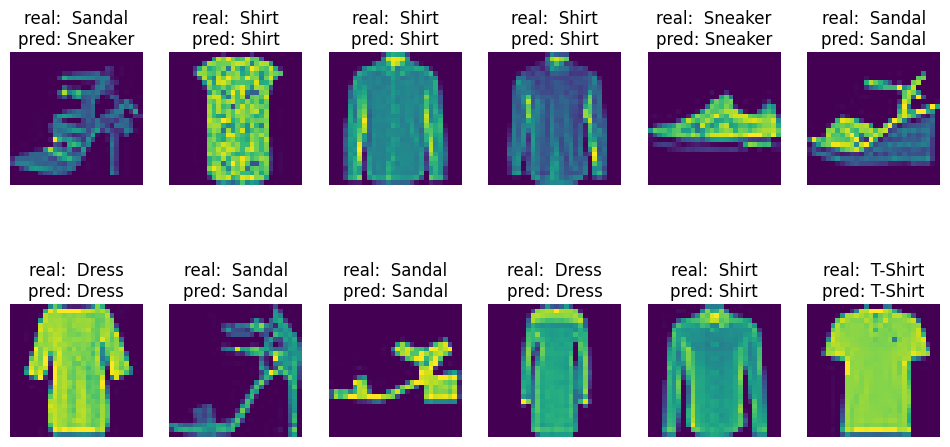

In [193]:

cols, rows = 6, 2
figure = plt.figure(figsize=(cols*2, rows*3))
with torch.no_grad():
    for i in range(0, cols*rows):
        image_index = random.randint(0, len(test_set)-1)
        image, real_label = test_set[image_index]
        outputs = model(image.unsqueeze(0))
        _, predicted_label = torch.max(outputs.data, 1)
        figure.add_subplot(rows, cols, i+1)
        plt.title("real:  "+labels_map[int(real_label)]+"\npred: "+labels_map[int(predicted_label)])
        plt.axis("off")
        plt.imshow(torch.mean(image, dim=0))
    plt.show()


In [194]:
class SiameseNetwork(nn.Module):
    def __init__(self, feature_extractor):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = feature_extractor
        self.fc1 = nn.Linear(2 * 2048, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x1, x2):
        x1 = self.feature_extractor(x1)
        x1 = x1.view(x1.size()[0], -1)

        x2 = self.feature_extractor(x2)
        x2 = x2.view(x2.size()[0], -1)

        # Concatenate the two feature vectors along the channel dimension
        merged = torch.cat((x1, x2), dim=1)

        # Pass the merged tensor through fully connected layers
        out = F.relu(self.fc1(merged))
        out = F.sigmoid(self.fc2(out))

        return out


In [195]:
feature_extractor = nn.Sequential(*list(model.resnext50.children())[:-1])
feature_extractor(images).shape

torch.Size([16, 2048, 1, 1])

In [196]:
siamese_net = SiameseNetwork(feature_extractor)

In [ ]:


# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)

# Train the network
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(tqdm(siamese_train_loader), 0):
        # Get the inputs and ground-truth labels
        
        input1, input2, labels = data
        label_var = labels.type(torch.FloatTensor)

        # Split the inputs into two images

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = siamese_net(input1, input2)
        loss = criterion(outputs, label_var.unsqueeze(1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')


In [39]:
torch.save(siamese_net.state_dict(), "siamese_net.pth")

In [198]:
siamese_net = SiameseNetwork(feature_extractor)

# Load the saved model
siamese_net.load_state_dict(torch.load("siamese_net.pth"))

<All keys matched successfully>

In [200]:
# Evaluate the siamese network on the validation set
correct = 0
total = 0

with torch.no_grad():
    siamese_net.eval()
    for data in siamese_test_loader:
        input1, input2, labels = data
        label_var = labels.type(torch.FloatTensor)

        outputs = siamese_net(input1, input2)
        # print(outputs.shape)

        # Convert the similarity scores to binary predictions (0 or 1)
        predicted = (outputs > 0.5).type(torch.FloatTensor)
        for i, real_label in enumerate(predicted):
            if real_label == label_var[i]:
                correct += 1
   
        total += label_var.size(0)


print('Accuracy of the siamese network on the validation set: %d %%' % (100 * correct / total))


Accuracy of the siamese network on the validation set: 83 %


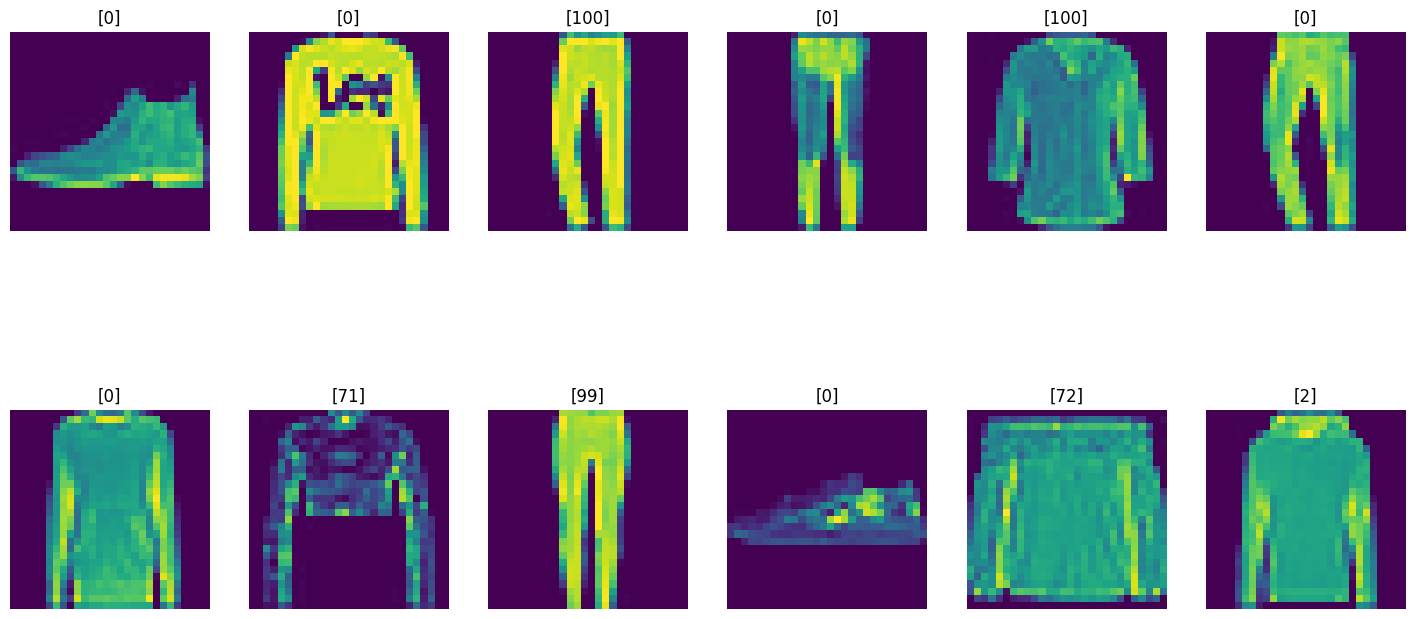

In [201]:

figure = plt.figure(figsize=(18, 9))
SIZE = 6
cols, rows = SIZE, 2
with torch.no_grad():
    for data in siamese_test_loader:
        input1, input2, labels = data
        label_var = labels.type(torch.FloatTensor)
        outputs = siamese_net(input1, input2)
        predicted = (outputs > 0.5).type(torch.FloatTensor)
        for i, real_label in enumerate(list(labels)[:SIZE]):
            figure.add_subplot(rows, cols, i+1)
            plt.title([int(real_label*100)])
            plt.axis("off")
            plt.imshow(torch.mean(input1[i], dim=0))

        for i, real_label in enumerate(list(outputs)[:SIZE]):
            figure.add_subplot(rows, cols, i+7)
            plt.title([int(real_label*100)])
            plt.axis("off")
            plt.imshow(torch.mean(input2[i], dim=0))

        plt.show()
        break

In [93]:
embeddings = []
labels = []
with torch.no_grad():
    for images, target in test_loader:
        embedding = feature_extractor(images).numpy()
        batch_size, n_features, height, width = embedding.shape
        embeddings_list = [embedding[i,:,:,:] for i in range(batch_size)]
        n_samples = len(embeddings_list)
        X_list = [embeddings_list[i].reshape(n_features * height * width) for i in range(n_samples)]
        embeddings += X_list
        labels += target.numpy().tolist()


embeddings = np.array(embeddings)
labels = np.array(labels)

# Visualize the embeddings using t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=5000, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

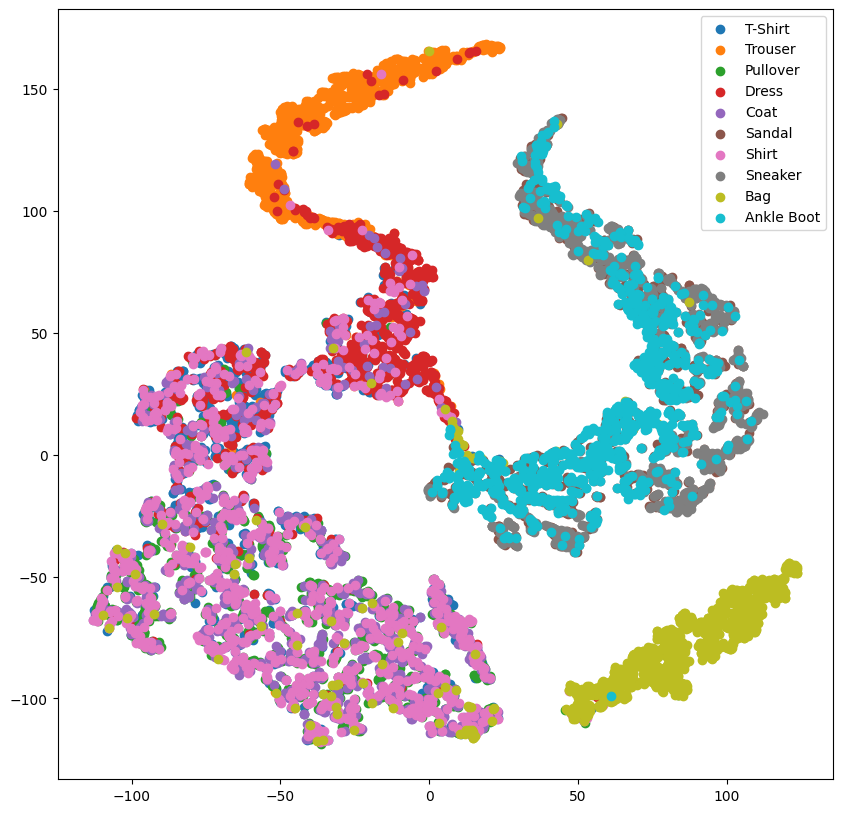

In [94]:
# Plot the embeddings
plt.figure(figsize=(10, 10))
for i in range(10):
    indices = np.where(labels == i)[0]
    plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], label=labels_map[i])
plt.legend()
plt.show()